In [1]:
import torch
import torch.nn as nn
from torch import optim 
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


In [56]:
torch.manual_seed(123)

In [57]:
transform = transforms.ToTensor() # Quando fazer o download as imagens, ja vai estar preparada para o pytorch

In [58]:
train = datasets.MNIST(root = '.', train = True, download=True, transform = transform)
test = datasets.MNIST(root = '.', train = False, download=True, transform = transform)

In [59]:
train.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [60]:
train.data.shape

torch.Size([60000, 28, 28])

In [7]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128)
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

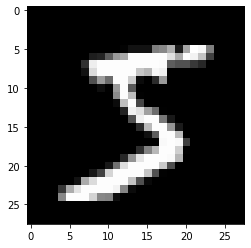

In [8]:
imagem = next(iter(train_loader))[0][0].view(28,28) # (1 imagem, 1 canal (preto e branco), 28px, 28px)
plt.imshow(imagem, cmap = 'gray')

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 784 BarContainer objects>)

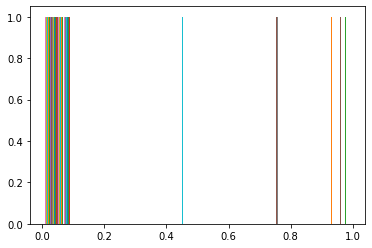

In [9]:
plt.hist(imagem.view(-1))

In [10]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [11]:
class classificador(nn.Module):
    def __init__(self):
        super().__init__()

        # Conv 2d por ter duas dimensões, 1 param = 1 canal preto e branco, 32 canais de saída, 32 filtros, detector de caracteristica 3x3
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size= (3,3))
        # Receberá os 32 canais de saída, os 32 filtros, o detector de característica
        self.conv2 = nn.Conv2d(32, 32, (3,3))
        # Enfativa e deixa mais branco
        self.activation = nn.ReLU()
        # Normalização dos dados nas camadas ocultas, valor = número de saídas
        self.bnorm = nn.BatchNorm2d(num_features=32)
        # Pega o mapa de características e pega os maiores valores
        self.pool = nn.MaxPool2d(kernel_size = (2,2))
        # Transforma em vetor
        self.flatten = nn.Flatten()

        # 32*5*5 = 800 ->  128
        # output = (input - filter + 1) / stride
        # convolução 1 : (28 - 3 + 1) / 1 (padrão) = 26x26
        # pooling 1: 13x13
        # convolução 2: (13 - 3 + 1) / 1 = 11
        # pooling 2: 5x5
        # 5 x 5 x 32 (32: mapa de características)
        self.linear1 = nn.Linear(in_features=32*5*5, out_features=128) 
        self.linear2 = nn.Linear(128,128)
        self.output = nn.Linear(128,10)
        self.dropout = nn.Dropout(p = 0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X


In [12]:
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [13]:
net

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [15]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [16]:
def training_loop(loader, epoch):
    running_loss = 0.
    running_accuracy = 0.
    
    for i, data in enumerate(loader):
        inputs, labels = data
                
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()        
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        ps = F.softmax(outputs)
        top_p, top_class = ps.topk(k = 1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)

        accuracy = torch.mean(equals.type(torch.float))

        running_accuracy += accuracy

              
        # Imprimindo os dados referentes a este loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.2f} - precisão {:03.2f}'.format(epoch + 1, i + 1, len(loader), loss, 
                                   accuracy), end = '\r')
        
    # Imprimindo os dados referentes a esta época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - precisão {:.5f}'.format(epoch+1, running_loss/len(loader), 
                     running_accuracy/len(loader)))

In [17]:
for epoch in range(5):
    print('Treinando...')
    training_loop(train_loader, epoch) # Treina
    net.eval() # Modo de teste
    print('Validando...')
    training_loop(test_loader, epoch) # Testa
    net.train() # Modo de treino

Treinando...


C:\Users\vitao\AppData\Local\Temp\ipykernel_1212\2702599588.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


ÉPOCA   1 FINALIZADA: perda 0.16260 - precisão 0.951649
Validando...
ÉPOCA   1 FINALIZADA: perda 0.12136 - precisão 0.965090
Treinando...
ÉPOCA   2 FINALIZADA: perda 0.05178 - precisão 0.985229
Validando...
ÉPOCA   2 FINALIZADA: perda 0.05959 - precisão 0.982400
Treinando...
ÉPOCA   3 FINALIZADA: perda 0.03774 - precisão 0.988748
Validando...
ÉPOCA   3 FINALIZADA: perda 0.04669 - precisão 0.984080
Treinando...
ÉPOCA   4 FINALIZADA: perda 0.02942 - precisão 0.990809
Validando...
ÉPOCA   4 FINALIZADA: perda 0.03855 - precisão 0.988330
Treinando...
ÉPOCA   5 FINALIZADA: perda 0.02668 - precisão 0.991429
Validando...
ÉPOCA   5 FINALIZADA: perda 0.02987 - precisão 0.989810


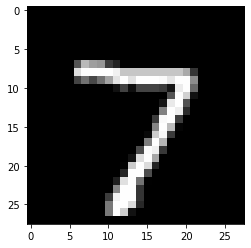

In [29]:
imagem = next(iter(test_loader))[0][0].view(28,28)
plt.imshow(imagem, cmap = 'gray')

In [30]:
# (1, 1, 28, 28) - (batch size, canais, altura x largura)

imagem.shape

torch.Size([28, 28])

In [31]:
imagem = imagem.view(1,1,28,28) # Troca a imagem para esse formato
imagem.shape

torch.Size([1, 1, 28, 28])

In [32]:
net.eval() # Entra no modo de avaliação
imagem = imagem.to(device) # Envia a imagem para onde ela deve ir e ser processada

In [48]:
previsao = net.forward(imagem) # Envia para a rede neural fazer a estimação

In [49]:
previsao # Retorna com valores logist, que no caso são valores das classes contendo a maior probabilidade de ser X númer

tensor([[-4.1643, -2.3998, -2.4763, -3.2069, -4.0691, -6.9175, -9.8898,  9.4484,
         -3.4834, -0.6604]], grad_fn=<AddmmBackward0>)

In [50]:
previsao = F.softmax(previsao) # Envia para a função softmax retornar valores

C:\Users\vitao\AppData\Local\Temp\ipykernel_1212\4240550013.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao) # Envia para a função softmax retornar valores


In [51]:
previsao

tensor([[1.2248e-06, 7.1512e-06, 6.6246e-06, 3.1903e-06, 1.3472e-06, 7.8048e-08,
         3.9947e-09, 9.9994e-01, 2.4196e-06, 4.0717e-05]],
       grad_fn=<SoftmaxBackward0>)

In [52]:
previsao = previsao.cpu().detach().numpy() # Descompacta os valores retornados pela função softmax

In [53]:
previsao[0][0] = 10

In [54]:
resultado = np.argmax(previsao) # Isso aqui eu tenho certeza que só ta pegando o maior valor dentro da array de previsão

In [55]:
resultado

0